<img style="float: right;" src="../htwlogo.jpg">

# Hough transformation for circles

**Author**: _Erik Rodner_<br>
**Lecture**: Computer Vision and Machine Learning I

Hough transformation can not be only used for lines but especially also for circles.
Your goal in this exercise is to find the errors in the notebook.

**Hints for the errors**
1. Edge detection in the beginning does not look perfect, can you spot why?
2. You need to adjust multiple parameters of the algorithm.
3. There is a missing line of code to convert circle parameters

In [1]:
# import our usual friends
from skimage.io import imread, imsave
import matplotlib.pylab as plt
import numpy as np
import skimage.data as examples
from skimage.color import rgb2gray
from skimage import feature, draw

### Finding edges in a proper example

The coin image in scikit-learn is of course perfect for circle estimation. For finding edge candidates, we use a Canny filter first.

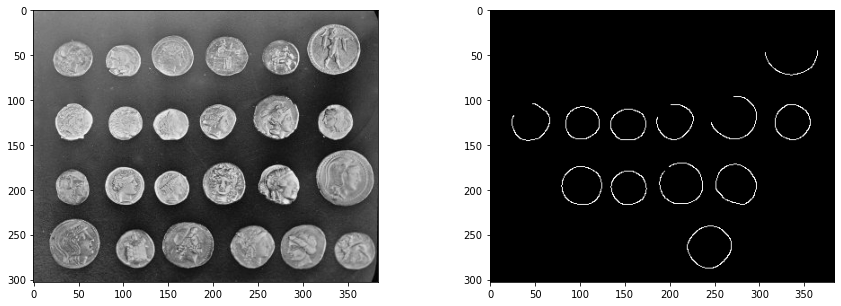

In [2]:
img = examples.coins()
edges = feature.canny(img, sigma=3, low_threshold=100, high_threshold=150)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(img, cmap=plt.cm.gray)
plt.subplot(1,2,2)
plt.imshow(edges, cmap=plt.cm.gray)


### Filling the hough accumulator

In contrast to lines, a circle has 3 parameters in 2D:
* $mx$ - x coordinate of the center point
* $my$ - y coordinate of the center point
* $r$ - radius of the circle

Therefore, our hough accumulator needs to be a 3-dimensional tensor. This might sound scary, but you can view it as multiple 2D center point hough accumulators - one for each radius. To reduce the size of the tensor, we need to limit
the possible radii of the circles we are looking for, which is done with ```radius_min``` and ```radius_max``` in the following code.

*Please note that there are versions that allow using 2D hough accumulators only by first finding suitable center points and afterwards determining the radius*

In [3]:
h, w = edges.shape
radius_min = 20
radius_max = 40
radius_range = np.arange(radius_min, radius_max)
hough_accu = np.zeros((h, w, len(radius_range)))

Similar to finding lines with the standard hough transform, we need to go to each edge candidate (first two outer loops) $(y,x)$. The question then is: to which circles defined by $(my, mx, r)$ can the pixel $(y,x)$ belong to? Theoretically it could belong to any possible radius $r$, therefore, we need to loop through all of them. Given a radius $r$, the possible center points of the circles all lie on one circle around $(y,x)$. This allows us to use a simple circle draw function for incrementing the hough accumulator.

In [4]:
for y in range(edges.shape[0]):
    for x in range(edges.shape[1]):
        # only use edge candidates
        if edges[y,x]:
            # go through all radii
            for ir, r in enumerate(radius_range):
                yy, xx = draw.circle_perimeter(y, x, radius=r, shape=edges.shape)
                hough_accu[yy, xx, ir] += 1

### Finding peaks in the accumulator with NMS

Now, let's find peaks in the accumulator. This sounds rather easy, but we will apply
non-maximum suppression to avoid finding maximas next to each other (similar circle parameters).
First, we define the maximum number of circles to extract and we define a utility function for 2D maximum determination:

In [5]:
num_circles = 24

In [6]:
def get_maximum_point(Z):
    """ utility function for getting a maximum position in 2D """
    return np.array(np.unravel_index(np.argmax(Z, axis=None), Z.shape))

Non-maximum suppression will be based on setting all values within a given neighbourhood
around the maximum to zero. There are better ways to do it - any ideas?

In [7]:
def suppress_point(Z, p, non_maximum_suppression_radius = (2,2,2)): 
    """ suppress a region around a point p in array Z """
    start = p - non_maximum_suppression_radius
    end = p + non_maximum_suppression_radius
    ry, rx, rr = draw.rectangle(start, end, shape=Z.shape)
    Z[ry, rx, rr] = 0
    return Z

Extract some local maxima always applying NMS afterwards:

In [8]:
h_maxima = np.zeros((num_circles, 3))
for i in range(num_circles):
    p = get_maximum_point(hough_accu)
    print (f"voting: {hough_accu[p[0], p[1], p[2]]}")
    hough_accu = suppress_point(hough_accu, p)
    h_maxima[i,:] = p

voting: 78.0
voting: 72.0
voting: 70.0
voting: 67.0
voting: 58.0
voting: 58.0
voting: 53.0
voting: 51.0
voting: 51.0
voting: 50.0
voting: 49.0
voting: 47.0
voting: 46.0
voting: 45.0
voting: 43.0
voting: 43.0
voting: 43.0
voting: 42.0
voting: 41.0
voting: 40.0
voting: 40.0
voting: 40.0
voting: 40.0
voting: 39.0


### Final visualization

In the end your result should look like this:
<img src="hough_circle_result.png">

All borders of the coins should be detected and maybe you can even achieve a better accuracy with your code!

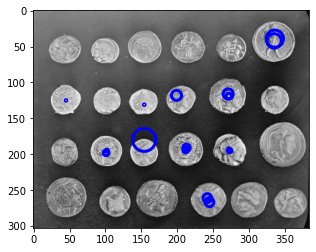

In [9]:
plt.imshow(img, cmap=plt.cm.gray)
for i in range(h_maxima.shape[0]):
    circle = plt.Circle((h_maxima[i,1], h_maxima[i,0]), h_maxima[i,2], color="blue", fill=False, linewidth=3)
    plt.gca().add_patch(circle)
plt.show()